# DT logs prediction model research

## Contents

* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Model training](#Model-training)
* [Inference](#Inference)
* [Metrics evaluation](#Metrics-evaluation)
* [Conclusion](#Conclusion)

## Problem description

Predict DT logs values based on other logs values and depth info.

In [1]:
%env CUDA_VISIBLE_DEVICES=1

import os
import sys

import torch
import pickle
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, "/notebooks/goryachev/petroflow")

from petroflow import WellDataset, WS
from petroflow.batchflow import Pipeline, B, V, C
from petroflow.batchflow.research import Research
from petroflow.batchflow.models.torch import TorchModel
from petroflow.models.logs_prediction.utils import build_dataset, calc_metrics, batch_mse, moving_average_1d

env: CUDA_VISIBLE_DEVICES=1


## Dataset

A dataset of 608 wells with filtered data.

In [2]:
FILTERED_DATASET_PATH = "../data/filtered/*"
filtered_dataset = WellDataset(path=FILTERED_DATASET_PATH, dirs=True)

DT values are predicted by GK, NKTD and GZ1 logs and depth info.

In [3]:
INPUTS_COL = ['GK', 'NKTD', 'GZ1', "DEPTH KM"]
TARGET_COL = ['DT']
PROPER_COL = INPUTS_COL + TARGET_COL

4 crops of length 6.4m will be sampled from each well in a batch.

In [4]:
N_CROPS = 8
CROP_SIZE = 64
REINDEXATION_STEP = 0.1
CROP_LENGTH = CROP_SIZE * REINDEXATION_STEP

Split logs by non nan segments.

In [5]:
split_pipeline = filtered_dataset >> Pipeline().drop_nans()
batch = split_pipeline.next_batch(filtered_dataset.size)
dataset = build_dataset(batch)
dataset.split(shuffle=11)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## Model architecture

Network of two dense layers is used for prediction:

* Second dense layer is preceded by activation and normalization layers.

* LeakyRelu is used as activation function.

* Adam optimizer with default parameters is used for model training. 

* Mean-squared error is used as a loss function.

Model configuration specification:

In [7]:
INPUTS_SIZE = len(INPUTS_COL)
TARGET_SIZE = len(TARGET_COL)

model_config = {
    'initial_block/inputs': 'inputs',
    'inputs/inputs': {'shape': [INPUTS_SIZE, CROP_SIZE]},
    'inputs/target': {'shape': [CROP_SIZE]},
    'loss': 'mse',
    'optimizer': 'Adam',
    'body/units': [CROP_SIZE*10, CROP_SIZE],
    'body/layout': 'fan f',
    'body/activation' : 'LeakyRelu',
    'device' : C('device')
}

## Research

Here train and test pipelines are run simultaneously to detect optimal train pipeline stop epoch.

In [8]:
res_name = 'optimal_stop'
def clear_previous_results(res_name):
    if os.path.exists(res_name):
        shutil.rmtree(res_name)

In [9]:
BATCH_SIZE = 32

train_template = (Pipeline()
    .add_namespace(np)
    .random_crop(CROP_LENGTH, N_CROPS)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .squeeze(B("target"), save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('train_loss')
    .init_model('dynamic', TorchModel, 'linear', model_config)
    .train_model('linear', B('inputs'), B('target'), fetches='loss', save_to=V('train_loss', mode='w'))
    .run_later(batch_size=BATCH_SIZE, shuffle=True, drop_last=True, n_epochs=None)
)

train_pipeline = dataset.train >> train_template

In [10]:
test_template = (Pipeline()
    .add_namespace(np)
    .crop(CROP_LENGTH, CROP_LENGTH)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .squeeze(B("target"), save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('prediction')
    .import_model('linear', train_pipeline)
    .predict_model('linear', B('inputs'), fetches='predictions', save_to=B('prediction'))
    .init_variable('test_loss')
    .batch_mse(B("target"), B("prediction"), save_to=V('test_loss', mode='w'))
    .run_later(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1)
)

test_pipeline = dataset.test >> test_template

In [11]:
TEST_EXECUTE_FREQ = ['#0', 50]

ITERATIONS = 1000

clear_previous_results(res_name)

research = (Research()
            .add_pipeline(train_pipeline, variables='train_loss', name='train_pipeline')
            .add_pipeline(test_pipeline, variables='test_loss', name='test_pipeline',
                          import_from='train_pipeline', run=True, execute=TEST_EXECUTE_FREQ))

research.run(n_iters=ITERATIONS, name=res_name, devices=[0], bar=True)

Research optimal_stop is starting...


Domain updated: 0:   0%|          | 0/1000.0 [00:11<?, ?it/s]/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

Domain updated: 0:   5%|▍         | 49/1000.0 [03:38<1:10:42,  4.46s/it] /usr/local/lib/pytho

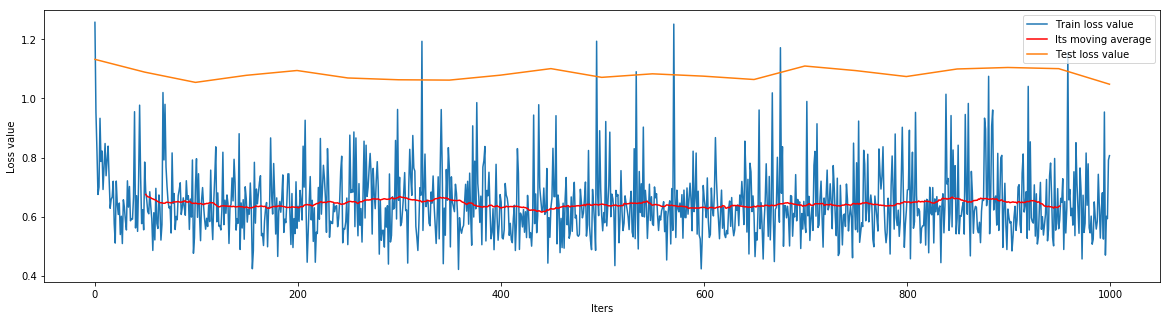

In [20]:
df = research.load_results()
train_loss = df[df['name'] == 'train_pipeline'][['iteration', 'train_loss']].values.T
test_loss = df[df['name'] == 'test_pipeline'][['iteration', 'test_loss']].values.T

fig = plt.figure(figsize=(20, 5))
plt.plot(*train_loss)
plt.plot(moving_average_1d(train_loss[1], 100), 'r')
plt.plot(*test_loss)
plt.xlabel("Iters")
plt.ylabel("Loss value")
plt.legend(["Train loss value", "Its moving average", "Test loss value"])
plt.show()

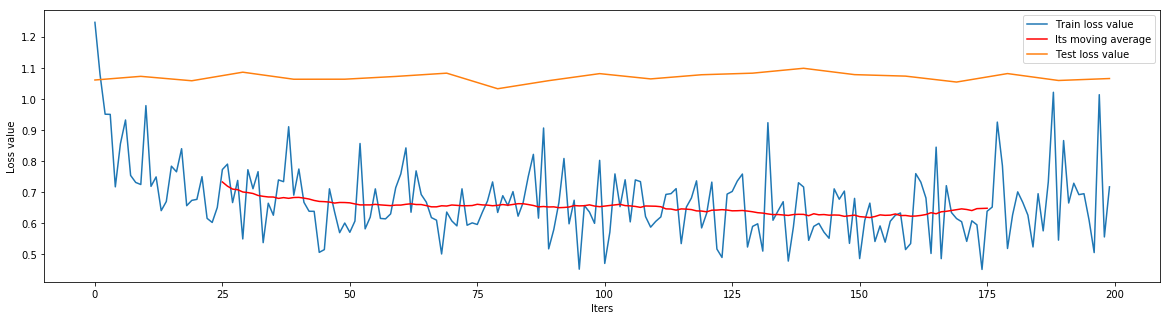

In [22]:
df = research.load_results()
train_loss = df[df['name'] == 'train_pipeline'][['iteration', 'train_loss']].values.T
test_loss = df[df['name'] == 'test_pipeline'][['iteration', 'test_loss']].values.T

fig = plt.figure(figsize=(20, 5))
plt.plot(*train_loss)
plt.plot(moving_average_1d(train_loss[1], 50), 'r')
plt.plot(*test_loss)
plt.xlabel("Iters")
plt.ylabel("Loss value")
plt.legend(["Train loss value", "Its moving average", "Test loss value"])
plt.show()

After first ~75 epochs train loss moving average value reaches the plateau.

Test loss value almost doesn't change during learning process and that's kinda sad.

## Inference

Inference pipeline is similar to the test one, but all predictions are stored in a pipeline now.

In [14]:
inference_template = (Pipeline()
    .add_namespace(np)
    .crop(CROP_LENGTH, CROP_LENGTH)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .squeeze(B("target"), save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('targets', default=[])
    .update(V('targets', mode='a'), B('target'))
    .init_variable('predictions', default=[])
    .update_config({'device': torch.device('cuda:0')})
    .import_model('linear', train_pipeline)
    .predict_model('linear', B('inputs'), fetches='predictions', save_to=V('predictions', mode='a'))
)

## Metrics evaluation

Three metrics used for model evaluation:
* Mean squared error (MSE)
* proportion of variance explained by model to data variance (R^2)

In [25]:
inference_pipeline = dataset.test >> inference_template
inference_pipeline.run(batch_size=1, n_iters=1, shuffle=True, drop_last=False)

true = np.concatenate([target.flatten() for target in inference_pipeline.v('targets')])
pred = np.concatenate([prediction.flatten() for prediction in inference_pipeline.v('predictions')])

metrics = calc_metrics(true, pred)

MSE: 1.112
R^2: -0.119


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Plot several randomly chosen predictions and compare them to random values sampled from $ \mathcal{N}( $ `true.mean()`, `true.std()` $ ) $.

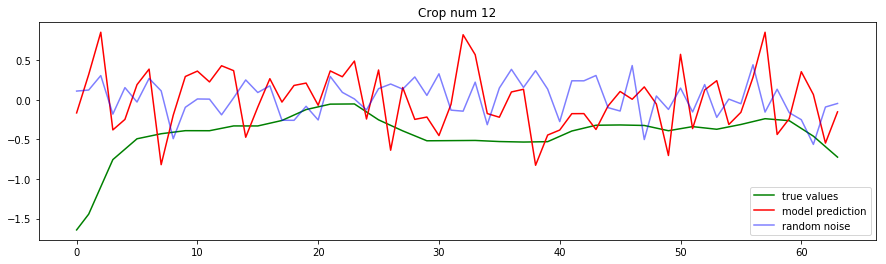

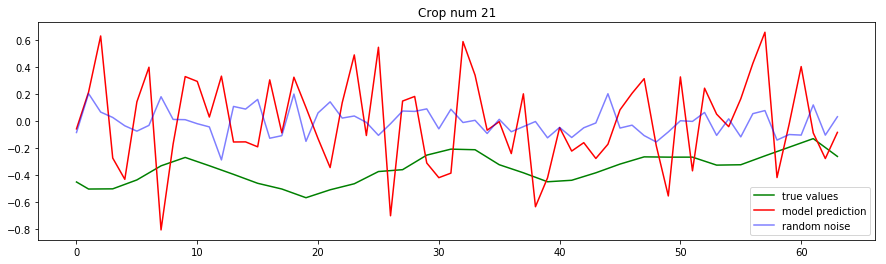

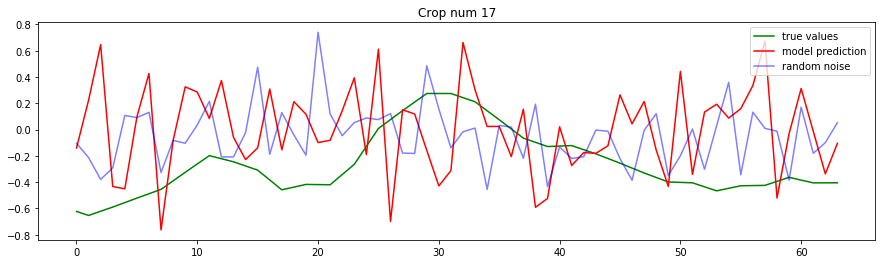

In [36]:
BATCH_NUM = np.random.randint(len(inference_pipeline.v('predictions')))
GRAPH_NUM = inference_pipeline.v('predictions')[BATCH_NUM].shape[0]
PRINT_NUM = 3
for crop_num in np.random.choice(GRAPH_NUM, PRINT_NUM, replace=False):
    true = inference_pipeline.v('targets')[BATCH_NUM][crop_num,:]
    pred = inference_pipeline.v('predictions')[BATCH_NUM][crop_num,:]
    norm = np.random.normal(scale=true.std(), size=true.shape)

    fig = plt.figure(figsize=(15, 4))
    plt.title("Crop num {}".format(crop_num))
    plt.plot(true, 'g')
    plt.plot(pred, 'r')
    plt.plot(norm, 'b', alpha=0.5)
    plt.legend(['true values', 'model prediction', 'random noise'])
    plt.show()

## Conclusion

Model performs poorly, predictions are indistinguishable from random noise.